In [58]:
import numpy as np
import sympy as symp
import scipy as scip
import matplotlib.pyplot as plt
import math as math

from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [59]:
#def rocket_performance(Name, Pc, dt, Tc, gamma_comb, gamma_exit, R_comb, R_exit, OF, Pa, g0, mass_dry, nozzle_expansion_ratio, density_ox, density_fuel, h1, h2, L_star, a, n, iter_num, CEA_res,insul_percentage, casing_percentage, disp):

def rocket_performance(Name, Pc, dt, OF, Pa, g0, mass_dry, nozzle_expansion_ratio, density_ox, density_fuel, h1, h2, L_star, a, n, iter_num, CEA_res,insul_percentage, casing_percentage, disp):
    
    #CEA Real Output : CEA_Me, CEA_v_sonic, CEA_c_star, CEA_Te, CEA_Pe, CEA_Isp
    CEA_Me, CEA_v_sonic, CEA_c_star, CEA_Te, CEA_Pe, CEA_Isp = CEA_res
    CEA_Isp = CEA_Isp/g0
    #print(CEA_Isp)
    CEA_ve = CEA_v_sonic*CEA_Me
    CEA_density_ISP = CEA_Isp * density_ox
    
    # Derived values
    At = math.pi/4*dt**2
    dt2 = math.sqrt(4 / math.pi * nozzle_expansion_ratio * At)  # Nozzle exit diameter
    Ae = nozzle_expansion_ratio * At  # Nozzle exit area in square meters
    '''
    gamma_avg = (gamma_comb + gamma_exit)/2
    R_avg = (R_comb + R_exit)/2
    
    # Step 2: Calculate Effective Exhaust Velocity (ve) and Specific Impulse (ISP)
    def exit_mach_number_func(M, nozzle_expansion_ratio, gamma):
        return (nozzle_expansion_ratio - (1 / M) * ((2 / (gamma + 1)) * (1 + (gamma - 1) / 2 * M**2))**((gamma + 1) / (2 * (gamma - 1))))

    Me = float(scip.optimize.fsolve(exit_mach_number_func, 5, args=(nozzle_expansion_ratio, gamma_avg))[0])
    Te = Tc * (1 + (gamma_avg - 1) / 2 * Me**2) ** -1
    Pe = Pc * (1 + (gamma_avg - 1) / 2 * Me**2) ** (-gamma_avg / (gamma_avg - 1))
    ve = Me * math.sqrt(gamma_exit * R_exit * Te)
    c_star = math.sqrt(R_comb*Tc)/(math.sqrt(gamma_comb)*(2/(gamma_comb+1))**((gamma_comb+1)/(2*gamma_comb-2)))
    ISP = ve / g0
    density_ISP = ISP * density_ox
    
    # Step 3: Calculate the mass flow rate (dot_m)
    mass_flow_rate = (Pc * At / math.sqrt(Tc)) * math.sqrt(gamma_comb / R_comb) * ((2 / (gamma_comb + 1)) ** ((gamma_comb + 1) / (2 * (gamma_comb - 1))))
    oxidizer_mass_flow_rate = mass_flow_rate * OF / (1 + OF)
    fuel_mass_flow_rate = mass_flow_rate - oxidizer_mass_flow_rate
    '''
    CEA_mass_flow_rate = Pc*At/CEA_c_star
    CEA_oxidizer_mass_flow_rate = CEA_mass_flow_rate * OF / (1 + OF)
    CEA_fuel_mass_flow_rate = CEA_mass_flow_rate - CEA_oxidizer_mass_flow_rate

    '''
    # Step 4: Calculate Thrust (Ft)
    thrust = mass_flow_rate * ve + (Pe - Pa) * Ae
    '''
    
    CEA_thrust = CEA_mass_flow_rate * CEA_ve + (CEA_Pe - Pa) * Ae

    # Step 5: Delta V Calculation
    R_E = 6378e3  # Earth's radius in meters
    mu = 3.985894e14  # Standard gravitational parameter for Earth in m^3/s^2

    # Initial and final orbital radii
    r1 = R_E + h1
    r2 = R_E + h2

    # Semi-major axis of the transfer orbit
    a_t = (r1 + r2) / 2

    # Orbital velocities
    v1 = math.sqrt(mu / r1)  # Initial orbit velocity
    vp = math.sqrt((2 * mu / r1) - (mu / a_t))  # Velocity at perigee of transfer orbit
    va = math.sqrt((2 * mu / r2) - (mu / a_t))  # Velocity at apogee of transfer orbit
    v2 = math.sqrt(mu / r2)  # Final orbit velocity

    # Delta V for each burn
    delta_v1 = vp - v1
    delta_v2 = v2 - va

    # Total Delta V
    delta_v_total = delta_v1 + delta_v2
    '''
    # Using Tsiolkovsky's rocket equation to find propellant mass
    mass_propellant = mass_dry * (math.exp(delta_v_total / ve) - 1)
    mass_oxidizer = mass_propellant * OF / (OF + 1)
    mass_fuel = mass_propellant-mass_oxidizer
    volume_fuel = (mass_propellant - mass_oxidizer)/density_fuel
    volume_oxidizer = mass_oxidizer/density_ox
    burn_time = mass_oxidizer / oxidizer_mass_flow_rate
    '''
    CEA_mass_propellant = mass_dry * (math.exp(delta_v_total / CEA_ve) - 1)
    CEA_mass_oxidizer = CEA_mass_propellant * OF / (OF + 1)
    CEA_mass_fuel = CEA_mass_propellant - CEA_mass_oxidizer
    CEA_volume_fuel = (CEA_mass_propellant - CEA_mass_oxidizer)/density_fuel
    CEA_volume_oxidizer = CEA_mass_oxidizer/density_ox
    CEA_burn_time = CEA_mass_oxidizer / CEA_oxidizer_mass_flow_rate
    
    '''
    # Calculate final mass after first burn
    mass_initial = mass_propellant + mass_dry
    mass_f1 = mass_initial * math.exp(-delta_v1 / ve)
    '''
    
    CEA_mass_initial = CEA_mass_propellant + mass_dry
    CEA_mass_f1 = CEA_mass_initial * math.exp(-delta_v1 / CEA_ve)
    
    '''
    # Calculate propellant mass required for first burn
    mass_propellant_parking = mass_initial - mass_f1
    '''
    
    CEA_mass_propellant_parking = CEA_mass_initial - CEA_mass_f1
    '''
    # Calculate final mass after second burn
    mass_f2 = mass_f1 * math.exp(-delta_v2 / ve)
    '''
    
    CEA_mass_f2 = CEA_mass_f1 * math.exp(-delta_v2 / CEA_ve)
    '''
    # Calculate propellant mass required for second burn
    mass_propellant_injection = mass_f1 - mass_f2
    '''
    CEA_mass_propellant_injection = CEA_mass_f1 - CEA_mass_f2
    
    '''
    parking_burn_time = mass_propellant_parking * OF / (OF+1) / oxidizer_mass_flow_rate
    injection_burn_time = mass_propellant_injection * OF / (OF+1) / oxidizer_mass_flow_rate
    '''
    CEA_parking_burn_time = CEA_mass_propellant_parking * OF / (OF+1) / CEA_oxidizer_mass_flow_rate
    CEA_injection_burn_time = CEA_mass_propellant_injection * OF / (OF+1) / CEA_oxidizer_mass_flow_rate

    # Calculate the orbital period at LEO (T)
    LEO_period = 2 * math.pi * math.sqrt(r1**3 / mu)
    
    '''
    # Calculate time to traverse 10 degrees of the orbit
    arc_degrees = parking_burn_time*360/LEO_period
    '''
    
    CEA_arc_degrees = CEA_parking_burn_time*360/LEO_period
    
    #Nozzle Length for 100% Bell Nozzle
    LN_cone = 0.8*(math.sqrt(nozzle_expansion_ratio)-1)*dt/2/math.tan(math.radians(15))
    
    #Bell Nozzle Length based on 15 deg Conical Nozzle
    #Lc = L_star*(dt/dc)**2
    #contraction_ratio = (dc/dt)**2
    
    #Dpi = math.sqrt((4*CEA_oxidizer_mass_flow_rate)/(math.pi*500))
    Dpi =2*dt
    # Define lower and upper bounds
    #lb = [200e-3, 0]  # Lower bounds Dpi, Dpf, L
    lb = [200e-3, 0]  # Lower bounds Dpf, L
    ub = [450e-3, 3.0]  # Upper bounds Dpf, L
    #ub = [math.sqrt(4/math.pi*CEA_oxidizer_mass_flow_rate/5), 3.0]  # Upper bounds Dpf, L
    bounds = [(low, high) for low, high in zip(lb, ub)]
    
    '''
    lb = [2*dt, 100e-3, 0]  # Lower bounds Dpi, Dpf, L
    ub = [450e-3, math.sqrt(4/math.pi*CEA_oxidizer_mass_flow_rate/5), 3.0]  # Upper bounds Dpi, Dpf, L
    bounds = [(low, high) for low, high in zip(lb, ub)]
    
    # Define the objective function (sum of squared residuals)
    def hybrid_equation(x, volume_fuel0, fuel_mass_flow_rate0, oxidizer_mass_flow_rate0, burn_time0):
        Dpi, Dpf, L = x

        # Fuel Volume Equation
        F1 = volume_fuel0 - (math.pi/4*(Dpf**2-Dpi**2)*L)
    
        # Fuel Mass Flow Rate Equation
        F2 = fuel_mass_flow_rate0 - (density_fuel*math.pi*Dpi*L*a*((4*oxidizer_mass_flow_rate0)/(math.pi*Dpi**2))**n)
    
        # Approximate Burn Time Relation
        F3 = burn_time0 - ((Dpf**(2*n+1)-Dpi**(2*n+1))*math.pi**n)/((2*n+1)*a*2**(2*n+1)*oxidizer_mass_flow_rate0**n)
    
        # Sum of squared residuals
        #return F1**2 + F2**2 + F3**2 + F4**2
        return [F1, F2, F3]
    '''
    
    
    # Define the objective function (sum of squared residuals)
    def hybrid_equation(x, volume_fuel0, fuel_mass_flow_rate0, oxidizer_mass_flow_rate0, burn_time0):
        Dpf, L = x
        # Fuel Volume Equation
        F1 = volume_fuel0 - (math.pi/4*(Dpf**2-Dpi**2)*L)
    
        # Fuel Mass Flow Rate Equation
        F2 = fuel_mass_flow_rate0 - (density_fuel*math.pi*Dpi*L*a*((4*oxidizer_mass_flow_rate0)/(math.pi*Dpi**2))**n)
    
        # Approximate Burn Time Relation
        F3 = burn_time0 - ((Dpf**(2*n+1)-Dpi**(2*n+1))*math.pi**n)/((2*n+1)*a*2**(2*n+1)*oxidizer_mass_flow_rate0**n)
    
        # Sum of squared residuals
        #return F1**2 + F2**2 + F3**2 + F4**2
        return [F1, F2, F3]
    
    # Normalization function for better scaling
    def normalize_residuals(residuals):
        # Scale each residual by a factor that brings them into a similar range
        scales = [1.0, 1, 1]  # Example scales, adjust as needed
        return [residuals[i] / scales[i] for i in range(len(residuals))]

    # Objective function for minimization (sum of squares of normalized residuals)
    def objective_function(x):
        residuals = hybrid_equation(x,CEA_volume_fuel, CEA_fuel_mass_flow_rate, CEA_oxidizer_mass_flow_rate, CEA_burn_time)
        normalized_residuals = normalize_residuals(residuals)
        return sum([r**2 for r in normalized_residuals])

   
    # Initial guesses for unknowns : Dpi, Dpf, L
    x0 = np.array([350e-3, 0.5])
    #x0 = np.array([108.1359e-3, 366.11e-3, 0.5])
    
    # Basin Hopping Methods: Powell
    result = scip.optimize.basinhopping(objective_function,x0=x0,minimizer_kwargs={"method": "Powell", "bounds": bounds},niter=iter_num,T=0.5,stepsize=0.001,disp=False)
    
    Dpf, Grain_Length = result.x[0], result.x[1]
    #Dpi, Dpf, Grain_Length = result.x[0], result.x[1], result.x[2]
    #CEA_Dpi, CEA_Dpf, CEA_Grain_Length = CEA_result.x[0], CEA_result.x[1], CEA_result.x[2]
    
    Throat_area = math.pi/4*(dt)**2
    Volume_chamber_Lstar = L_star*Throat_area
    Volume_chamber_grain = math.pi/4*(Dpi)**2
    Volume_post_chamber = (Volume_chamber_Lstar-Volume_chamber_grain)
    Length_post_chamber = Volume_post_chamber/(math.pi/4*Dpf**2)
    Length_connector = (Dpf-dt)*0.5/math.tan(math.radians(60))
    #14 multi-port reduction in length by 70%
    Length_precombustor = 0.015
    Total_combustor_length = Length_post_chamber + Grain_Length + Length_precombustor
    
    Maximum_pump_diameter = 0.300
    Total_engine_length = Total_combustor_length + Length_connector + LN_cone
    Total_kickstage_length = Total_engine_length + Maximum_pump_diameter
    
    #Tank Geometry
    rho_tank = 2840 # Al-2219
    rho_insul = 417 # PU Foam
    rho_casing = 1550 # Carbon Fiber Composite
    rho_combustor = 21030 # Rhenium
    yield_combustor = 290e6 # Rhenium
    t_insul = 10e-3 # PU Foam
    t_tank = 1e-3 # Al-2219
    Do = 913.40e-3
    Di = 450e-3
    width = Do/2-Di/2-2*t_tank-2*t_insul
    R = Di/2+t_insul+width/2+t_tank
    def tank_geom(h):
        return CEA_volume_oxidizer-((math.pi*width**2/4 + width*h)*(2*math.pi*R))
    result = scip.optimize.fsolve(tank_geom, 0.3)
    h = float(result)
    #t_tank = Pc*(R+width/2)/yield_combustor
    volume_tank = ((math.pi*(width+2*t_tank)**2/4 + (width+2*t_tank)*(h))*(2*math.pi*R))-((math.pi*width**2/4 + width*h)*(2*math.pi*R))
    volume_insul = ((math.pi*(width+2*t_tank+2*t_insul)**2/4 + (width+2*t_tank+2*t_insul)*(h))*(2*math.pi*R))-((math.pi*(width+2*t_tank)**2/4 + (width+2*t_tank)*(h))*(2*math.pi*R))
    
    mass_comb = (1/(Total_combustor_length/Dpf)+2)*rho_combustor/yield_combustor*2*Pc*Volume_chamber_Lstar
    mass_injector = 1/3*mass_comb
    mass_nozzle = rho_combustor/yield_combustor*2*(At*((nozzle_expansion_ratio-1)/math.sin(math.radians(15)))*(Dpf*Pc)/2)
    mass_battery = CEA_oxidizer_mass_flow_rate*16e5/density_ox/(0.65*0.92)/(265*3600)*CEA_burn_time
    mass_pump = 12
    mass_motor = 0.5
    mass_tank = rho_tank*volume_tank
    mass_insul = rho_insul*volume_insul*insul_percentage
    mass_casing = rho_casing*1.619*10**-2*casing_percentage
    mass_other = 10
    mass_dry_kickstage = mass_comb + mass_injector + mass_nozzle + mass_battery + mass_pump + mass_motor + mass_tank + mass_insul + mass_casing + mass_other
    mass_payload = 100
    total_kickstage_wet_mass = CEA_mass_propellant + mass_dry_kickstage + mass_payload
    thrust_to_weight = CEA_thrust/(total_kickstage_wet_mass*g0)
    new_dry_mass = mass_dry_kickstage + mass_payload
    
    def plot_orbit_and_burn_arc(orbit_radius, arc_degrees):
        """
        Visualize the orbit and highlight the arc corresponding to a burn.
    
        Parameters:
        - orbit_radius: Radius of the orbit (in arbitrary units, e.g., km or AU)
        - arc_degrees: Arc length in degrees over which the burn occurs
        """
        # Full circle (orbit) points
        theta_full = np.linspace(0, 2 * np.pi, 1000)
        x_full = orbit_radius * np.cos(theta_full)
        y_full = orbit_radius * np.sin(theta_full)
        x_earth = 6378 * np.cos(theta_full)
        y_earth = 6378 * np.sin(theta_full)
        
        # Arc for the burn
        arc_radians = np.deg2rad(arc_degrees / 2)
        theta_arc = np.linspace(-arc_radians, arc_radians, 100)
        x_arc = orbit_radius * np.cos(theta_arc)
        y_arc = orbit_radius * np.sin(theta_arc)
    
        # Plotting the full orbit
        plt.figure(figsize=(6, 6))
        plt.plot(x_full, y_full, label='Orbit', linestyle='--')
        plt.plot(x_earth, y_earth, label='Orbit', linestyle='-', color='blue')
        
        # Highlighting the arc
        plt.plot(x_arc, y_arc, color='red', label=f'Burn Arc ({arc_degrees:.2f} degrees)', linestyle='-', linewidth=4)
    
        # Plot aesthetics
        plt.title(f"Orbit and Burn Arc of {arc_degrees:.2f} Degrees")
        plt.xlabel('X Position in km')
        plt.ylabel('Y Position in km')
        plt.axhline(0, color='black', linewidth=0)
        plt.axvline(0, color='black', linewidth=0)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.show()
        
        return
    
    if disp:
        print(f"\nUsing {Name}\n")
        
        # Print basic parameters
        print(f"Oxidizer to Fuel Ratio = {OF}:1")
        print(f"Chamber pressure = {Pc*1e-6:.2f} MPa")
        #print(f"Chamber temperature = {Tc} K")
        print(f"Throat diameter = {dt*1000} mm")
        print(f"Throat Area = {At*10**6:.4f} mm^2")
        print(f"Nozzle expansion ratio = {nozzle_expansion_ratio}")
        print(f"Nozzle exit diameter = {dt2:.4f} m")
        print(f"Nozzle exit area = {Ae:.4f} m^2")
        
        '''
        print(f"\nUsing basic compressible fluid equation with constant properties assumption (without integral over volume)")
        print(f"    Exhaust mach number = {Me:.4f}")
        print(f"    Effective exhaust velocity = {ve:.4f} m/s")
        print(f"    C* Efficiency = {c_star:.4f} m/s")
        print(f"    Exhaust temperature = {Te:.4f} K")
        print(f"    Exhaust pressure = {Pe:.4f} Pa")
        print(f"    Specific Impulse (Isp) = {ISP:.4f} s")
        print(f"    Density Impulse = {density_ISP:.4f} kg-s/m^3")
        '''
        print(f"\nUsing NASA-CEA Result (accounting for the change in properties)")
        print(f"    CEA Exhaust mach number = {CEA_Me:.4f}")
        print(f"    CEA Effective exhaust velocity = {CEA_ve:.4f} m/s")
        print(f"    CEA C* Efficiency = {CEA_c_star:.4f} m/s")
        print(f"    CEA Exhaust temperature = {CEA_Te:.4f} K")
        print(f"    CEA Exhaust pressure = {CEA_Pe:.4f} Pa")
        print(f"    CEA Specific Impulse (Isp) = {CEA_Isp:.4f} s")
        print(f"    CEA Density Impulse = {CEA_density_ISP:.4f} kg-s/m^3")
    
        print(f"\nAll performance after this is calculated with NASA-CEA Results")
        print(f"\nPropellant Mass Flow Rate = {CEA_mass_flow_rate:.4f} Kg/s")
        print(f"Fuel Mass Flow Rate = {CEA_fuel_mass_flow_rate:.4f} Kg/s")
        print(f"Oxidizer Mass Flow Rate = {CEA_oxidizer_mass_flow_rate:.4f} Kg/s")
        print(f"Oxidizer Volumetric Flow Rate = {CEA_oxidizer_mass_flow_rate/1600*1000:.4f} L/s")
        
        print(f"\nThrust = {CEA_thrust:.4f} N")
        print(f"Thrust to Weight Ratio = {CEA_thrust/CEA_mass_initial/g0:.4f}")
        print(f"\nDelta V total = {delta_v_total:.4f} m/s")
        print(f"Total propellant mass used = {CEA_mass_propellant:.4f} kg")
        print(f"    Fuel mass used= {CEA_mass_fuel:.4f} kg")
        print(f"    Fuel volume = {CEA_volume_fuel*1000:.4f} L")
        print(f"    Oxidizer mass used= {CEA_mass_oxidizer:.4f} kg")
        print(f"    Oxidizer volume = {CEA_volume_oxidizer*1000:.4f} L")
        print(f"    Propellant mass used at parking = {CEA_mass_propellant_parking:.4f} kg")
        print(f"    Propellant mass used at injection = {CEA_mass_propellant_injection:.4f} kg")
        print(f"Dry mass = {mass_dry:.4f} kg")
        print(f"Total LEO wet mass = {CEA_mass_initial:.4f} kg")
        print(f"Total burn time = {CEA_burn_time:.2f} s")
        print(f"    Parking burn time = {CEA_parking_burn_time:.2f} s")
        print(f"    Injection burn time = {CEA_injection_burn_time:.2f} s")
        print(f"Orbital arc degrees over parking burn = {CEA_arc_degrees:.2f} deg")
        
        print(f"\nOxidizer Tank Geometry")
        print(f"Tank Height = {h*1000:.0f} mm")
        
        print(f"\nApproximated Ideal Hybrid Fuel Performance and Sizing")
        print(f"Fuel Grain Geometry")
        print(f"    Initial Port Diameter = {Dpi*1000:.4f} mm")
        print(f"    Final Port Diameter = {Dpf*1000:.4f} mm")
        print(f"    Fuel Grain Length = {Grain_Length*1000:.4f} mm")
        #print(f"    Approximate Multiport Fuel Grain Length = {Grain_Length*0.3*1000:.4f} mm")
        print(f"    Fuel grain volume = {(math.pi/4*(Dpf**2-Dpi**2)*Grain_Length)*1000:.4f} L")
        print(f"Hybrid fuel burn time = {((Dpf**(2*n+1)-Dpi**(2*n+1))*math.pi**n)/((2*n+1)*a*2**(2*n+1)*CEA_oxidizer_mass_flow_rate**n):.4f} s")
        print(f"Hybrid fuel mass flow rate = {(density_fuel*math.pi*Dpi*Grain_Length*a*((4*CEA_oxidizer_mass_flow_rate)/(math.pi*Dpi**2))**n):.4f} kg/s")
        print(f"Oxidizer mass flux initial= {CEA_oxidizer_mass_flow_rate/(math.pi/4*Dpi**2):.4f} kg/s-m^3")
        print(f"Oxidizer mass flux final= {CEA_oxidizer_mass_flow_rate/(math.pi/4*Dpf**2):.4f} kg/s-m^3")
        print(f"L* chamber volume = {Volume_chamber_Lstar*1000:.4f} L")
        print(f"Grain chamber volume = {Volume_chamber_grain*1000:.4f} L")
        print(f"Pre combustion chamber length = {Length_precombustor*1000:.4f} mm")
        print(f"Post combustion chamber length = {Length_post_chamber*1000:.4f} mm")
        print(f"Total combustion chamber length = {Total_combustor_length*1000:.4f} mm")
        print(f"Nozzle Length (LN) = {LN_cone*1000:.2f} mm")
        print(f"Total engine length = {Total_engine_length*1000:.4f} mm")
        print(f"Total kick stage length = {Total_kickstage_length*1000:.4f} mm")
        
        print(f"\nMass Calculation")
        print(f"Combustion chamber mass = {mass_comb:.4f} kg")
        print(f"Injector mass = {mass_injector:.4f} kg")
        print(f"Nozzle mass = {mass_nozzle:.4f} kg")
        print(f"Battery mass = {mass_battery:.4f} kg")
        print(f"Pump mass = {mass_pump:.4f} kg")
        print(f"Motor mass = {mass_motor:.4f} kg")
        print(f"Tank mass = {mass_tank:.4f} kg")
        print(f"Tank Insulation mass = {mass_insul:.4f} kg")
        print(f"Casing mass = {mass_casing:.4f} kg")
        print(f"Other mass = {mass_other:.4f} kg")
        print(f"Payload mass = {mass_payload:.4f} kg")
        print(f"Kick stage dry mass = {mass_dry_kickstage:.4f} kg")
        print(f"Total kick stage wet mass = {total_kickstage_wet_mass:.4f} kg")
        
        print(f"New thrust to weight ratio = {thrust_to_weight:.4f}")
        
        plot_orbit_and_burn_arc(r1/1000, CEA_arc_degrees)
    
    
    
    return [dt, thrust_to_weight, new_dry_mass, mass_dry, mass_dry_kickstage, total_kickstage_wet_mass]

#CEA-Run Hybrid Engine JANUS Compound 15 + HAN+H2O2

#CEA Real Output : CEA_Me, CEA_v_sonic, CEA_c_star, CEA_Te, CEA_Pe, CEA_Isp
#Real Run  # A 
set_of_cea_results = {1e5:{50:[3.8825,774.01,1571.2,1511.2,2.11460,3171.2],
                                55:[3.9448,766.87,1571.2,1480.6,1.87080,3186.8],
                                60:[4.0026,760.26,1571.2,1452.9,1.67290,3200.7],
                                65:[4.0564,754.12,1571.2,1427.7,1.50950,3213.2],
                                70:[4.1066,748.43,1571.2,1404.6,1.37250,3224.5],
                                75:[4.1538,743.12,1571.2,1383.4,1.25620,3234.8],
                                80:[4.1982,738.15,1571.2,1363.7,1.15640,3244.3],
                                85:[4.2401,733.49,1571.2,1345.5,1.06990,3253.0],
                                90:[4.2799,729.11,1571.2,1328.4,0.99436,3261.1],
                                95:[4.3177,724.97,1571.2,1312.4,0.92781,3268.7],
                                100:[4.3537,721.05,1571.2,1297.4,0.86880,3275.7],
                                105:[4.3881,717.33,1571.2,1283.2,0.81618,3282.3],
                                110:[4.4210,713.79,1571.2,1269.7,0.76898,3288.5],
                                115:[4.4526,710.41,1571.2,1257.0,0.72644,3294.4],
                                120:[4.4829,707.18,1571.2,1244.9,0.68793,3300.0],
                                125:[4.5122,704.10,1571.2,1233.4,0.65291,3305.2],
                                130:[4.5404,701.13,1571.2,1222.4,0.62095,3310.2],
                                135:[4.5676,698.29,1571.2,1211.9,0.59167,3315.0],
                                140:[4.5939,695.55,1571.2,1201.8,0.56477,3319.5],
                                145:[4.6194,692.92,1571.2,1192.1,0.53998,3323.9],
                                150:[4.6441,690.38,1571.2,1182.9,0.51706,3328.0],
                                155:[4.6680,687.92,1571.2,1174.0,0.49582,3332.0],
                                160:[4.6913,685.55,1571.2,1165.4,0.47609,3335.8],
                                },
                      2.5e5:{50:[3.9395,767.63,1585.9,1482.5,5.1054,3186.0],
                                55:[4.0035,760.24,1585.9,1452.0,4.5166,3201.2],
                                60:[4.0625,753.50,1585.9,1424.6,4.0389,3214.8],
                                65:[4.1171,747.29,1585.9,1399.7,3.6444,3226.9],
                                70:[4.1680,741.55,1585.9,1376.9,3.3138,3237.9],
                                75:[4.2157,736.23,1585.9,1356.0,3.0331,3248.0],
                                80:[4.2605,731.26,1585.9,1336.6,2.7923,3257.2],
                                85:[4.3028,726.60,1585.9,1318.6,2.5835,3265.8],
                                90:[4.3429,722.22,1585.9,1301.8,2.4011,3273.6],
                                95:[4.3811,718.09,1585.9,1286.0,2.2404,3281.0],
                                100:[4.4174,714.18,1585.9,1271.2,2.0980,3287.9],
                                105:[4.4521,710.47,1585.9,1257.2,1.9710,3294.3],
                                110:[4.4853,706.94,1585.9,1244.0,1.8570,3300.4],
                                115:[4.5171,703.58,1585.9,1231.4,1.7543,3306.1],
                                120:[4.5477,700.36,1585.9,1219.5,1.6613,3311.5],
                                125:[4.5772,697.29,1585.9,1208.2,1.5768,3316.7],
                                130:[4.6056,694.34,1585.9,1197.3,1.4996,3321.5],
                                135:[4.6331,691.51,1585.9,1187.0,1.4289,3326.2],
                                140:[4.6596,688.78,1585.9,1177.1,1.3640,3330.6],
                                145:[4.6853,686.16,1585.9,1167.6,1.3041,3334.8],
                                150:[4.7103,683.63,1585.9,1158.4,1.2488,3338.9],
                                155:[4.7344,681.19,1585.9,1149.6,1.1975,3342.8],
                                160:[4.7579,678.82,1585.9,1141.2,1.1498,3346.5],
                                },
                      5e5:{50:[3.9802,762.97,1596.5,1462.9,9.9667,3195.9],
                           55:[4.0448,755.54,1596.5,1432.6,8.8175,3210.9],
                           60:[4.1042,748.77,1596.5,1405.4,7.8851,3224.2],
                           65:[4.1593,742.55,1596.5,1380.8,7.1153,3236.1],
                           70:[4.2105,736.82,1596.5,1358.2,6.4700,3247.0],
                           75:[4.2584,731.49,1596.5,1337.5,5.9222,3256.8],
                           80:[4.3035,726.53,1596.5,1318.3,5.4521,3265.9],
                           85:[4.3461,721.88,1596.5,1300.4,5.0446,3274.3],
                           90:[4.3864,717.51,1596.5,1283.8,4.6885,3282.0],
                           95:[4.4247,713.39,1596.5,1268.2,4.3749,3289.3],
                           100:[4.4612,709.49,1596.5,1253.5,4.0968,3296.0],
                           105:[4.4961,705.79,1596.5,1239.7,3.8488,3302.4],
                           110:[4.5295,702.27,1596.5,1226.6,3.6263,3308.3],
                           115:[4.5616,698.92,1596.5,1214.2,3.4258,3314.0],
                           120:[4.5924,695.72,1596.5,1202.4,3.2443,3319.3],
                           125:[4.6220,692.65,1596.5,1191.1,3.0792,3324.3],
                           130:[4.6506,689.71,1596.5,1180.4,2.9285,3329.1],
                           135:[4.6782,686.89,1596.5,1170.2,2.7905,3333.7],
                           140:[4.7049,684.17,1596.5,1160.4,2.6637,3338.0],
                           145:[4.7308,681.56,1596.5,1151.0,2.5467,3342.2],
                           150:[4.7558,679.03,1596.5,1141.9,2.4387,3346.2],
                           155:[4.7802,676.60,1596.5,1133.2,2.3385,3350.0],
                           160:[4.8038,674.24,1596.5,1124.9,2.2455,3353.6],
                           },
                      7.5e5:{50:[4.0027,760.40,1602.4,1452.2,14.7530,3201.2],
                             55:[4.0675,752.95,1602.4,1422.1,13.0520,3216.0],
                             60:[4.1272,746.18,1602.4,1395.1,11.6720,3229.2],
                             65:[4.1823,739.96,1602.4,1370.5,10.5330,3241.1],
                             70:[4.2337,734.23,1602.4,1348.1,9.5779,3251.8],
                             75:[4.2818,728.92,1602.4,1327.5,8.7672,3261.6],
                             80:[4.3270,723.96,1602.4,1308.4,8.0713,3270.6],
                             85:[4.3697,719.32,1602.4,1290.6,7.4682,3278.9],
                             90:[4.4102,714.95,1602.4,1274.1,6.9410,3286.5],
                             95:[4.4486,710.84,1602.4,1258.6,6.4768,3293.7],
                             100:[4.4852,706.95,1602.4,1244.0,6.0652,3300.4],
                             105:[4.5202,703.25,1602.4,1230.2,5.6981,3306.7],
                             110:[4.5537,699.74,1602.4,1217.2,5.3688,3312.6],
                             115:[4.5858,696.39,1602.4,1204.9,5.0719,3318.2],
                             120:[4.6167,693.19,1602.4,1193.1,4.8031,3323.4],
                             125:[4.6465,690.13,1602.4,1182.0,4.5588,3328.4],
                             130:[4.6752,687.20,1602.4,1171.3,4.3357,3333.2],
                             135:[4.7029,684.38,1602.4,1161.1,4.1314,3337.7],
                             140:[4.7297,681.67,1602.4,1151.4,3.9436,3342.0],
                             145:[4.7556,679.06,1602.4,1142.0,3.7705,3346.1],
                             150:[4.7807,676.54,1602.4,1133.0,3.6105,3350.1],
                             155:[4.8052,674.11,1602.4,1124.4,3.4622,3353.8],
                             160:[4.8289,671.76,1602.4,1116.1,3.3245,3357.5],
                             },
                      10e5:{50:[4.0180,758.65,1606.5,1445.0,19.4940,3204.8],
                            55:[4.0830,751.20,1606.5,1415.0,17.2470,3219.5],
                            60:[4.1427,744.42,1606.5,1388.1,15.4240,3232.6],
                            65:[4.1980,738.21,1606.5,1363.6,13.9190,3244.4],
                            70:[4.2495,732.49,1606.5,1341.3,12.6570,3255.0],
                            75:[4.2977,727.17,1606.5,1320.7,11.5850,3264.8],
                            80:[4.3430,722.22,1606.5,1301.7,10.6660,3273.7],
                            85:[4.3858,717.58,1606.5,1284.0,9.8691,3281.9],
                            90:[4.4263,713.23,1606.5,1267.5,9.1725,3289.6],
                            95:[4.4648,709.12,1606.5,1252.1,8.5591,3296.7],
                            100:[4.5015,705.23,1606.5,1237.6,8.0152,3303.3],
                            105:[4.5365,701.54,1606.5,1223.8,7.5301,3309.6],
                            110:[4.5701,698.03,1606.5,1210.9,7.0949,3315.4],
                            115:[4.6023,694.69,1606.5,1198.6,6.7027,3321.0],
                            120:[4.6333,691.49,1606.5,1186.9,6.3475,3326.2],
                            125:[4.6631,688.43,1606.5,1175.8,6.0245,3331.2],
                            130:[4.6918,685.50,1606.5,1165.2,5.7297,3335.9],
                            135:[4.7196,682.69,1606.5,1155.0,5.4597,3340.4],
                            140:[4.7464,679.98,1606.5,1145.3,5.2116,3344.7],
                            145:[4.7724,677.37,1606.5,1136.0,4.9828,3348.8],
                            150:[4.7977,674.85,1606.5,1127.0,4.7714,3352.7],
                            155:[4.8221,672.43,1606.5,1118.4,4.5754,3356.4],
                            160:[4.8459,670.08,1606.5,1110.1,4.3934,3360.0],
                            },
                      20e5:{50:[4.0526,754.68,1615.9,1428.9,38.2000,3212.7],
                            55:[4.1179,747.24,1615.9,1399.2,33.7980,3227.2],
                            60:[4.1779,740.47,1615.9,1372.4,30.2270,3240.1],
                            65:[4.2334,734.27,1615.9,1348.2,27.2780,3251.7],
                            70:[4.2851,728.56,1615.9,1326.0,24.8050,3262.3],
                            75:[4.3335,723.26,1615.9,1305.7,22.7070,3271.8],
                            80:[4.3790,718.32,1615.9,1286.8,20.9050,3280.6],
                            85:[4.4220,713.69,1615.9,1269.3,19.3430,3288.8],
                            90:[4.4627,709.34,1615.9,1252.9,17.9780,3296.3],
                            95:[4.5013,705.24,1615.9,1237.6,16.7760,3303.3],
                            100:[4.5382,701.37,1615.9,1223.2,15.7100,3309.9],
                            105:[4.5734,697.69,1615.9,1209.6,14.7600,3316.0],
                            110:[4.6071,694.19,1615.9,1196.8,13.9070,3321.8],
                            115:[4.6395,690.85,1615.9,1184.6,13.1380,3327.3],
                            120:[4.6706,687.66,1615.9,1173.0,12.4420,3332.4],
                            125:[4.7005,684.61,1615.9,1162.0,11.8090,3337.3],
                            130:[4.7294,681.69,1615.9,1151.4,11.2310,3342.0],
                            135:[4.7573,678.88,1615.9,1141.4,10.7020,3346.4],
                            140:[4.7843,676.18,1615.9,1131.8,10.2150,3350.6],
                            145:[4.8105,673.58,1615.9,1122.5,9.7671,3354.7],
                            150:[4.8358,671.07,1615.9,1113.6,9.3527,3358.5],
                            155:[4.8604,668.65,1615.9,1105.1,8.9685,3362.2],
                            160:[4.8843,666.31,1615.9,1096.9,8.6117,3365.8],
                            },
                      30e5:{50:[4.0714,752.54,1621.2,1420.3,56.667,3217.0],
                            55:[4.1368,745.10,1621.2,1390.7,50.139,3231.4],
                            60:[4.1970,738.34,1621.2,1364.1,44.842,3244.2],
                            65:[4.2526,732.15,1621.2,1339.9,40.467,3255.7],
                            70:[4.3044,726.44,1621.2,1317.9,36.800,3266.1],
                            75:[4.3529,721.15,1621.2,1297.6,33.687,3275.6],
                            80:[4.3985,716.21,1621.2,1278.8,31.014,3284.4],
                            85:[4.4416,711.59,1621.2,1261.4,28.698,3292.4],
                            90:[4.4824,707.25,1621.2,1245.1,26.673,3299.9],
                            95:[4.5211,703.16,1621.2,1229.8,24.890,3306.8],
                            100:[4.5581,699.29,1621.2,1215.5,23.309,3313.4],
                            105:[4.5934,695.61,1621.2,1202.0,21.897,3319.5],
                            110:[4.6272,692.12,1621.2,1189.2,20.633,3325.2],
                            115:[4.6596,688.79,1621.2,1177.1,19.492,3330.6],
                            120:[4.6908,685.60,1621.2,1165.5,18.459,3335.7],
                            125:[4.7208,682.56,1621.2,1154.6,17.520,3340.6],
                            130:[4.7498,679.64,1621.2,1144.1,16.663,3345.2],
                            135:[4.7778,676.83,1621.2,1134.1,15.878,3349.6],
                            140:[4.8049,674.14,1621.2,1124.5,15.156,3353.8],
                            145:[4.8311,671.54,1621.2,1115.3,14.491,3357.8],
                            150:[4.8565,669.03,1621.2,1106.5,13.876,3361.6],
                            155:[4.8812,666.61,1621.2,1098.0,13.306,3365.3],
                            160:[4.9051,664.28,1621.2,1089.8,12.777,3368.8],
                            },
                      40e5:{50:[4.0840,751.09,1624.8,1414.5,74.991,3219.8],
                            55:[4.1496,743.66,1624.8,1385.0,66.353,3234.1],
                            60:[4.2098,736.90,1624.8,1358.4,59.344,3246.9],
                            65:[4.2655,730.72,1624.8,1334.4,53.556,3258.3],
                            70:[4.3174,725.01,1624.8,1312.4,48.703,3268.7],
                            75:[4.3660,719.73,1624.8,1292.2,44.583,3278.1],
                            80:[4.4117,714.80,1624.8,1273.5,41.046,3286.8],
                            85:[4.4548,710.18,1624.8,1256.1,37.981,3294.9],
                            90:[4.4956,705.85,1624.8,1239.8,35.301,3302.3],
                            95:[4.5345,701.76,1624.8,1224.6,32.941,3309.2],
                            100:[4.5715,697.89,1624.8,1210.3,30.848,3315.7],
                            105:[4.6069,694.21,1624.8,1196.9,28.981,3321.8],
                            110:[4.6407,690.73,1624.8,1184.1,27.307,3327.5],
                            115:[4.6732,687.40,1624.8,1172.0,25.798,3332.9],
                            120:[4.7045,684.22,1624.8,1160.5,24.431,3338.0],
                            125:[4.7345,681.18,1624.8,1149.6,23.188,3342.8],
                            130:[4.7636,678.26,1624.8,1139.2,22.054,3347.4],
                            135:[4.7916,675.46,1624.8,1129.2,21.014,3351.8],
                            140:[4.8187,672.76,1624.8,1119.6,20.059,3355.9],
                            145:[4.8450,670.17,1624.8,1110.5,19.179,3359.9],
                            150:[4.8704,667.66,1624.8,1101.7,18.365,3363.7],
                            155:[4.8952,665.25,1624.8,1093.2,17.611,3367.4],
                            160:[4.9192,662.91,1624.8,1085.0,16.910,3370.9],
                            },
                      50e5:{50:[4.0935,750.02,1627.6,1410.2,93.214,3221.9],
                            55:[4.1591,742.59,1627.6,1380.7,82.478,3236.2],
                            60:[4.2194,735.84,1627.6,1354.3,73.767,3248.9],
                            65:[4.2752,729.65,1627.6,1330.2,66.572,3260.3],
                            70:[4.3271,723.95,1627.6,1308.3,60.540,3270.6],
                            75:[4.3758,718.67,1627.6,1288.1,55.419,3280.0],
                            80:[4.4215,713.74,1627.6,1269.5,51.023,3288.7],
                            85:[4.4647,709.13,1627.6,1252.1,47.213,3296.7],
                            90:[4.5056,704.80,1627.6,1235.9,43.882,3304.1],
                            95:[4.5444,700.71,1627.6,1220.8,40.948,3311.0],
                            100:[4.5815,696.85,1627.6,1206.5,38.347,3317.4],
                            105:[4.6169,693.18,1627.6,1193.1,36.026,3323.5],
                            110:[4.6508,689.69,1627.6,1180.3,33.945,3329.2],
                            115:[4.6833,686.36,1627.6,1168.3,32.069,3334.5],
                            120:[4.7146,683.19,1627.6,1156.8,30.370,3339.6],
                            125:[4.7448,680.15,1627.6,1145.9,28.825,3344.4],
                            130:[4.7738,677.23,1627.6,1135.5,27.415,3349.0],
                            135:[4.8019,674.43,1627.6,1125.5,26.123,3353.3],
                            140:[4.8291,671.74,1627.6,1116.0,24.936,3357.5],
                            145:[4.8554,669.15,1627.6,1106.9,23.841,3361.5],
                            150:[4.8809,666.64,1627.6,1098.1,22.830,3365.3],
                            155:[4.9056,664.23,1627.6,1089.6,21.892,3368.9],
                            160:[4.9297,661.89,1627.6,1081.5,21.021,3372.4],
                            },
                      60e5:{50:[4.1010,749.17,1629.8,1406.8,111.360,3223.6],
                            55:[4.1667,741.74,1629.8,1377.4,98.535,3237.8],
                            60:[4.2270,734.99,1629.8,1351.0,88.129,3250.4],
                            65:[4.2828,728.81,1629.8,1327.0,79.533,3261.8],
                            70:[4.3348,723.12,1629.8,1305.1,72.328,3272.1],
                            75:[4.3835,717.83,1629.8,1285.0,66.210,3281.5],
                            80:[4.4293,712.91,1629.8,1266.3,60.958,3290.1],
                            85:[4.4725,708.30,1629.8,1249.0,56.406,3298.1],
                            90:[4.5134,703.97,1629.8,1232.9,52.427,3305.5],
                            95:[4.5523,699.89,1629.8,1217.7,48.922,3312.3],
                            100:[4.5894,696.02,1629.8,1203.5,45.815,3318.8],
                            105:[4.6249,692.35,1629.8,1190.1,43.041,3324.8],
                            110:[4.6588,688.87,1629.8,1177.4,40.556,3330.5],
                            115:[4.6914,685.55,1629.8,1165.3,38.314,3335.8],
                            120:[4.7227,682.37,1629.8,1153.9,36.284,3340.9],
                            125:[4.7529,679.33,1629.8,1143.0,34.438,3345.7],
                            130:[4.7820,676.42,1629.8,1132.6,32.753,3350.3],
                            135:[4.8101,673.62,1629.8,1122.7,31.210,3354.6],
                            140:[4.8373,670.93,1629.8,1113.1,29.791,3358.7],
                            145:[4.8636,668.34,1629.8,1104.0,28.484,3362.7],
                            150:[4.8891,665.84,1629.8,1095.3,27.275,3366.5],
                            155:[4.9139,663.42,1629.8,1086.8,26.155,3370.1],
                            160:[4.9380,661.09,1629.8,1078.7,25.114,3373.6],
                            },
                      }
    
Pressure_Keys = [1e5, 2.5e5, 5e5, 7.5e5, 10e5, 20e5, 30e5, 40e5, 50e5, 60e5]
#Pressure_Keys = [7.5e5]
#initial guess for iterations
mass_dry0 = 99.0408+100
dt0 = 0.04805

#c in y=f(x;p;c)
target_TW = 0.500

nozzle_expansion_ratio0 = [50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160]

'''
Rocket_Performance_Library  = {1e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               2.5e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               5e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               7.5e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               10e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               20e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               30e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               40e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               50e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               60e5:{'dt':[],
                                         'wet_mass':[],
                                         'kickstage_dry_mass':[],
                                         'TW':[],
                                        },
                               }

for pressure in Pressure_Keys:
    count = 0
    for ratio in nozzle_expansion_ratio0:
        while True:
            count += 1
            #print(count)
            
            #Iterate until mass is constant
            while True:
                result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=pressure, dt=dt0, OF=5.2, Pa=0, g0=9.807, mass_dry=mass_dry0, nozzle_expansion_ratio=ratio, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=6.35e-05, n=0.5, iter_num=500, CEA_res = set_of_cea_results[pressure][ratio], insul_percentage=1.0, casing_percentage=1.0, disp=False)
                mass_dry0 = result[2]
                old_mass_dry = result[3]
                current_TW = result[1]
                #print(f"Current T/W {current_TW}")
                if round(abs(mass_dry0-old_mass_dry),5) == 0:
                    #print(old_mass_dry)
                    #print(mass_dry0)
                    #print(f"Current T/W {current_TW}")
                    
                    
                    #result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=10e5, dt=dt0, Tc=2933.5, gamma_comb=1.1225, gamma_exit=1.2249, R_comb=359.4664851, R_exit=345.1988624, OF=4.2, Pa=0, g0=9.807, mass_dry=mass_dry0, nozzle_expansion_ratio=100, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=9.39216799e-05, n=0.5, iter_num=1000, CEA_res = set_of_cea_results, insul_percentage=1.0, casing_percentage=1.0, disp=False)
                    break
            factor = 2*(max(current_TW,target_TW)/min(current_TW,target_TW))
            if (round(current_TW,4) > round(target_TW,4)) and count == 1:
                #print(f"If #1")
                #print(f"start : {dt0:.5f}")
                max0 = dt0
                min0 = 0
                dt0 = (max0+min0)/2
                #print(f"new : {dt0:.5f}")
                #print(f"max : {max0:.5f}")
                #print(f"min : {min0:.5f}")
                
            elif (round(current_TW,4) < round(target_TW,4)) and count == 1:
                #print(f"If #2")
                #print(f"start : {dt0:.5f}")
                min0 = dt0
                max0 = dt0*5
                dt0 = (max0+min0)/2
                #print(f"new : {dt0:.5f}")
                #print(f"max : {max0:.5f}")
                #print(f"min : {min0:.5f}")
                
            elif (round(current_TW,4) == round(target_TW,4)) and count == 1:
                #print(f"If #3")
                result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=pressure, dt=dt0, OF=5.2, Pa=0, g0=9.807, mass_dry=mass_dry0, nozzle_expansion_ratio=ratio, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=6.35e-05, n=0.5, iter_num=500, CEA_res = set_of_cea_results[pressure][ratio], insul_percentage=1.0, casing_percentage=1.0, disp=False)
                Rocket_Performance_Library[pressure]['dt'].append(result[0])
                Rocket_Performance_Library[pressure]['wet_mass'].append(result[5])
                Rocket_Performance_Library[pressure]['kickstage_dry_mass'].append(result[4])
                Rocket_Performance_Library[pressure]['TW'].append(result[1])
                break
                
            elif round(current_TW,4) > round(target_TW,4):
                #print(f"If #4")
                #print(f"start : {dt0:.5f}")
                max0 = dt0
                dt0 = (max0+min0)/2
                #print(f"new : {dt0:.5f}")
                #print(f"max : {max0:.5f}")
                #print(f"min : {min0:.5f}")
                
            elif round(current_TW,4) < round(target_TW,4):
                #print(f"If #5")
                #print(f"start : {dt0:.5f}")
                min0 = dt0
                dt0 = (max0+min0)/2
                #print(f"new : {dt0:.5f}")
                #print(f"max : {max0:.5f}")
                #print(f"min : {min0:.5f}")
                
            else :
                result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=pressure, dt=dt0, OF=5.2, Pa=0, g0=9.807, mass_dry=mass_dry0, nozzle_expansion_ratio=ratio, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=6.35e-05, n=0.5, iter_num=500, CEA_res = set_of_cea_results[pressure][ratio], insul_percentage=1.0, casing_percentage=1.0, disp=False)
                Rocket_Performance_Library[pressure]['dt'].append(result[0])
                Rocket_Performance_Library[pressure]['wet_mass'].append(result[5])
                Rocket_Performance_Library[pressure]['kickstage_dry_mass'].append(result[4])
                Rocket_Performance_Library[pressure]['TW'].append(result[1])
                break  
        print(f"Ae/At of {ratio} of Pressure {pressure/100000} bar Completed")
        count = 0
    print(f"Pressure {pressure/100000} bar All Completed")
'''
# FOR HIGHER PRESSURE THAN 10 BAR PLEASE RECHECK THE VALUE IN MASS CALCULATION. WALL THICKNESS SHOULD BE THICKER (YOU CAN ADD CODE TO CALCULATE THE WALL THICKNESS (THE EQUATION YOU DERIVED))


#
#rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=10e5, dt=0.04495, Tc=2933.5, gamma_comb=1.1225, gamma_exit=1.2249, R_comb=359.4664851, R_exit=345.1988624, OF=4.2, Pa=0, g0=9.807, mass_dry=76.2734+100, nozzle_expansion_ratio=60, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=9.39216799e-05, n=0.5, iter_num=1000, CEA_res = set_of_cea_results, insul_percentage=0.5, casing_percentage=0.735, disp=True)

#rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=10e5, dt=0.04761, Tc=2933.5, gamma_comb=1.1225, gamma_exit=1.2249, R_comb=359.4664851, R_exit=345.1988624, OF=4.2, Pa=0, g0=9.807, mass_dry=112.8390+20, nozzle_expansion_ratio=140, density_ox=1550, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=9.39216799e-05, n=0.5, iter_num=1000, CEA_res = set_of_cea_results, disp=True)


'\nRocket_Performance_Library  = {1e5:{\'dt\':[],\n                                         \'wet_mass\':[],\n                                         \'kickstage_dry_mass\':[],\n                                         \'TW\':[],\n                                        },\n                               2.5e5:{\'dt\':[],\n                                         \'wet_mass\':[],\n                                         \'kickstage_dry_mass\':[],\n                                         \'TW\':[],\n                                        },\n                               5e5:{\'dt\':[],\n                                         \'wet_mass\':[],\n                                         \'kickstage_dry_mass\':[],\n                                         \'TW\':[],\n                                        },\n                               7.5e5:{\'dt\':[],\n                                         \'wet_mass\':[],\n                                         \'kickstage_dry_mass\':[],

In [60]:
#print(Rocket_Performance_Library)
Rocket_Performance_Library = {100000.0: {'dt': [0.15209185791015625, 0.15123782648146156, 0.15053628382932588, 0.14998500349303684, 0.14952728558686912, 0.14914397589481293, 0.14885267906689337, 0.14861646265724132, 0.14843504607684918, 0.1483082094896253, 0.14821768934223173, 0.14816341040326364, 0.14814532404945463, 0.14816340819545676, 0.1481995809025357, 0.14825385320999512, 0.1483443401809485, 0.1484529908207295, 0.1485798427415968, 0.14870680305643946, 0.14887017722971924, 0.14905190352028286, 0.14923385164469727], 'wet_mass': [709.0351389438016, 705.752539557623, 703.3848873128063, 701.8078642474286, 700.8268143945309, 700.3199393146273, 700.2820652109112, 700.6093585997677, 701.2260919890098, 702.1484378411875, 703.3186310606097, 704.7071401171444, 706.310600570135, 708.10540447583, 710.0707871401524, 712.1335705731267, 714.4010618037478, 716.7882531408443, 719.3133635008168, 721.9026741797413, 724.6533547447405, 727.5448919070107, 730.4803887863131], 'kickstage_dry_mass': [91.61874697092324, 92.39319857941544, 93.21671530425435, 94.09044613769878, 94.9972034327065, 95.93068931651553, 96.8993335597905, 97.89105359468405, 98.90532737327136, 99.94492940127247, 101.0032989490399, 102.08087310024891, 103.17903704548903, 104.29846948984817, 105.43224031424236, 106.57851358778281, 107.7501644084142, 108.93722943673704, 110.14117186312114, 111.35111427643965, 112.58921950360156, 113.84681094875224, 115.11138361138002], 'TW': [0.499993613227021, 0.499999313443914, 0.49996653493473225, 0.5000342187913552, 0.5000336867396967, 0.4999768901094812, 0.5000045432413645, 0.4999768799168029, 0.49998778795136717, 0.5000210471754547, 0.5000148217881933, 0.5000077603789879, 0.5000071923395817, 0.5000450944824283, 0.500012902305206, 0.5000007960266089, 0.5000204516497879, 0.5000391384239732, 0.5000375362523733, 0.4999663875604006, 0.49999094415786904, 0.4999994792504684, 0.4999681064640356]}, 250000.0: {'dt': [0.09557561067552542, 0.09502726427638605, 0.0945632639625365, 0.09419387621268285, 0.09388917190120386, 0.09363702812900823, 0.0934312827058732, 0.09326020491771547, 0.09312359328941805, 0.09300991702807843, 0.09293044078061792, 0.09287372054088365, 0.09283970916861525, 0.09282837619630463, 0.09282837619630463, 0.09283970778519578, 0.09286237372947928, 0.09290771668540188, 0.09296442305544911, 0.09303251223249168, 0.09310065127953696, 0.09319156988430213, 0.09329395320082542], 'wet_mass': [697.8176447034681, 694.2551858506664, 691.5371395438024, 689.6072814487925, 688.2621495460934, 687.3803614298214, 686.9411834445546, 686.8550096415523, 687.0702756001806, 687.5191863721398, 688.2543820250961, 689.2005203245482, 690.3549267169308, 691.7023543184623, 693.2095839303676, 694.8328973339663, 696.6128223320493, 698.5290450333608, 700.6048942951113, 702.7771690597506, 705.0207875432314, 707.4431348159776, 709.9762515874241], 'kickstage_dry_mass': [90.14259510459458, 90.75774643336986, 91.41721510641452, 92.12817112340201, 92.8756127198105, 93.65321542803464, 94.46094755553099, 95.29246581297973, 96.14756124298042, 97.01970199704877, 97.91873400843835, 98.83725962227632, 99.7766994500658, 100.73780641398969, 101.71402101154584, 102.70385586365258, 103.71038039814796, 104.74027770691369, 105.78924544451208, 106.85459189492505, 107.92814165336846, 109.03184802944943, 110.15535302125008], 'TW': [0.5000295490969031, 0.5000467200794628, 0.49996774991792026, 0.49998165367013947, 0.49999989290713903, 0.5000358270009782, 0.5000493419654732, 0.5000179503197292, 0.500006116413562, 0.49996545238011436, 0.49996834424120307, 0.4999756783786965, 0.4999936925370898, 0.5000439855116651, 0.5000350084833722, 0.5000212953485376, 0.49995663048289174, 0.5000034541458804, 0.5000015604920429, 0.500028300218932, 0.4999785197481295, 0.5000015811239349, 0.5000436561376252]}, 500000.0: {'dt': [0.06735112783565447, 0.06696471389421456, 0.06664591215570452, 0.0663855765613463, 0.06616677644328522, 0.06598908246357915, 0.06583603161313872, 0.0657154822388471, 0.0656111974159583, 0.06553511021192368, 0.06547111108085735, 0.06542315860692118, 0.06539121370525763, 0.06537524905347412, 0.06536726867639239, 0.06536726867639239, 0.06538322748222158, 0.06539919018424362, 0.06543112338257577, 0.06546307217328992, 0.06551101875935433, 0.06555900046254723, 0.06561502011626277], 'wet_mass': [691.3626033774804, 687.7916086914992, 685.0908459549278, 683.0798987381746, 681.6450282987687, 680.7154080618336, 680.1392230866119, 679.919795854355, 679.9922281977616, 680.3403022388779, 680.9065498674452, 681.6720256159487, 682.633924316544, 683.7541504474057, 685.0331833718619, 686.4720853217245, 688.0460885293463, 689.716645983966, 691.5398482750965, 693.4229712070698, 695.4869767621957, 697.5769404035991, 699.8109663145856], 'kickstage_dry_mass': [89.41041152471833, 89.9739506911702, 90.58704463225506, 91.24271724215956, 91.93204254746132, 92.65512051253157, 93.39910746983006, 94.17086312580653, 94.96039038769072, 95.77566573084442, 96.60597603480413, 97.45407716903578, 98.32121354883826, 99.2067047958137, 100.10627381525066, 101.02081604869102, 101.95573841399253, 102.89785495575882, 103.86325372352125, 104.83486925481772, 105.8333593030856, 106.83715311212364, 107.8605292152979], 'TW': [0.5000097858719963, 0.4999936238891694, 0.4999701068236917, 0.5000164583909394, 0.500004528116957, 0.5000183213364731, 0.4999804462068299, 0.5000192303380302, 0.49995260570509975, 0.5000000537486213, 0.4999701992270781, 0.49995435593708026, 0.4999585001699569, 0.5000316735426377, 0.5000425828489187, 0.49999199432812796, 0.5000460865332399, 0.4999854157450949, 0.5000130919117209, 0.49997328178144673, 0.49999318846210267, 0.4999893575048799, 0.49995832262806933]}, 750000.0: {'dt': [0.0549141330465207, 0.05460577731896456, 0.05434581329120093, 0.05413684196323794, 0.053958412430400116, 0.053813504584517696, 0.053688692989412, 0.05359038605644798, 0.05351188451437311, 0.05344656238972177, 0.05339436848113806, 0.05335526127766066, 0.05332920890398993, 0.05330967916440106, 0.05330317163520619, 0.05330317163520619, 0.05330967837002494, 0.05332269342822075, 0.05334222078177112, 0.053374778289572496, 0.053407355668899634, 0.05344647238447744, 0.0534921419775794], 'wet_mass': [688.4368664878506, 684.9440208955358, 682.2357638480838, 680.28712770355, 678.8443870241358, 677.8685522365556, 677.2907339055148, 677.0472761976891, 677.099415968848, 677.4013149145985, 677.9259412512461, 678.6594564269724, 679.5699752415119, 680.6494566738353, 681.8830297687391, 683.2356948551364, 684.7174055990827, 686.3320138388348, 688.0541683531068, 689.9228373670293, 691.8776304654874, 693.8985787014318, 696.0444200987026], 'kickstage_dry_mass': [89.16165830692161, 89.71396863015768, 90.30855053923308, 90.95085729960535, 91.62169217882514, 92.32426433678714, 93.04993305176238, 93.80203634728156, 94.57659337091962, 95.36856777376484, 96.17798520878455, 97.00550067577231, 97.85075508500393, 98.70936664833647, 99.58674342392779, 100.47662335332768, 101.38030650704755, 102.29877221440746, 103.23130515397672, 104.18714813549231, 105.151229406925, 106.12907009637684, 107.12492999952653], 'TW': [0.49999786226855336, 0.5000083728540604, 0.49997905145565613, 0.49999569804453126, 0.49997054288276693, 0.5000147120485238, 0.49995077676665806, 0.49998838992669276, 0.5000458592200339, 0.5000498189668279, 0.5000352866446354, 0.5000214414719274, 0.5000497212311038, 0.4999996984658394, 0.5000244932772401, 0.50003602715028, 0.500024045106171, 0.4999858893863662, 0.499954209036552, 0.5000186567304516, 0.49998526768018287, 0.5000138793982186, 0.5000362984733334]}, 1000000.0: {'dt': [0.047517372701519206, 0.04725345174718337, 0.04703425848956704, 0.046850530917342176, 0.04670183538464553, 0.04657641541657154, 0.046468389062455956, 0.046383302900842575, 0.046309696585204035, 0.04625316619386467, 0.04621364322470488, 0.046179795341483657, 0.04615160943124105, 0.046140341948469756, 0.04612907721654874, 0.04612907721654874, 0.04614033919829107, 0.04615160392954065, 0.04616850515168282, 0.04619104836708891, 0.04621924114563328, 0.04625309312889424, 0.04629261603562059], 'wet_mass': [686.6208071838835, 683.1524304943816, 680.530921059324, 678.5572779825657, 677.1314017532095, 676.1778872834496, 675.5886833462791, 675.3430004023793, 675.3644598633653, 675.6553165412238, 676.1855186549651, 676.9104084628768, 677.7801965726065, 678.843941627522, 680.0306309972746, 681.3782997265026, 682.876480135291, 684.4453199010127, 686.1570259567411, 687.9651236788696, 689.8612010452784, 691.8718999931816, 693.9773429862695], 'kickstage_dry_mass': [89.03101446323485, 89.57650054807748, 90.16922970465198, 90.79908717592677, 91.46517148875378, 92.15950815412963, 92.87531757129585, 93.61791907323324, 94.37703290293724, 95.15879668952958, 95.9635207961062, 96.7809682752933, 97.60930489078066, 98.46228446018164, 99.3218399911399, 100.20128328249493, 101.10128568099702, 102.0069565631453, 102.92860928979199, 103.86426137791064, 104.81409461601406, 105.78041082428344, 106.76272558135628], 'TW': [0.4999600301586588, 0.5000035845709168, 0.49999372251499674, 0.49996717795689627, 0.5000414385188534, 0.5000461855484478, 0.49998266034918776, 0.5000080474322904, 0.49995566777116757, 0.4999557885990684, 0.5000479785059025, 0.500025835464367, 0.4999519288757084, 0.5000331471719239, 0.4999610826984753, 0.4999566675174369, 0.5000355588096297, 0.5000300704598774, 0.4999876300209402, 0.49996648749374295, 0.4999786019140138, 0.49999390280722816, 0.500038273130806]}, 2000000.0: {'dt': [0.033552540003844875, 0.03336823039689016, 0.0332175193953417, 0.03309181833317671, 0.03298679058944348, 0.03289820301705972, 0.03282591692644607, 0.032765810877386406, 0.03271781408410898, 0.032677875346213345, 0.03264596335857056, 0.032626037843825346, 0.032610107161284416, 0.03259816498336891, 0.03259418571518247, 0.03259418571518247, 0.032598164497618404, 0.032606123033872704, 0.032618063752757186, 0.032633990541698965, 0.0326539087488167, 0.03267782518588858, 0.032703753636048286], 'wet_mass': [682.8881621176242, 679.5134970108861, 676.9679543799654, 675.0753327976588, 673.6975244927888, 672.7634078231371, 672.2126290716993, 671.9779481140891, 672.0338908788653, 672.3416052193041, 672.8244531398309, 673.5486819922853, 674.4360191216754, 675.4626020304281, 676.6574717018639, 677.9869010591927, 679.417016765548, 680.973963895274, 682.6327790458275, 684.3844300369338, 686.263908521828, 688.2264066909862, 690.2730111649932], 'kickstage_dry_mass': [88.81074087363324, 89.34680910803321, 89.93141392285777, 90.55382813606222, 91.2074231248496, 91.8879601235581, 92.59503363489482, 93.32354981948596, 94.07413805193805, 94.84222657966217, 95.62513650970726, 96.43238013534567, 97.25179470149553, 98.08284952935782, 98.93304834860668, 99.79643660186753, 100.6717963726506, 101.5613205920216, 102.46425846835761, 103.3807446922294, 104.3135638153405, 105.26070920590618, 106.2197288653825], 'TW': [0.500018530772997, 0.5000176288269704, 0.5000422163411792, 0.5000384908602846, 0.5000412040708506, 0.500005839520101, 0.5000065667710064, 0.49999671867452894, 0.5000092769765172, 0.49996301296945256, 0.499954406557673, 0.5000356660043533, 0.5000422650058539, 0.500005211033289, 0.5000231743044572, 0.5000073746446227, 0.5000010781879298, 0.4999741301870519, 0.49995883747899794, 0.49996799716217905, 0.49996111851741987, 0.4999943575270058, 0.5000008335011589]}, 3000000.0: {'dt': [0.027378215629396872, 0.027227822599206097, 0.02710484537311105, 0.027005584464762256, 0.02691987338125593, 0.026850864916777614, 0.02679186643429446, 0.026746079553181163, 0.02670690072571068, 0.02667429952853574, 0.02665150654798157, 0.026631986401584123, 0.026618982501973976, 0.02661248372694908, 0.02660923513274413, 0.02660923513274413, 0.02661248333039217, 0.026618980518705256, 0.026628728680516304, 0.026641730989442336, 0.026659617893793154, 0.02667914398111771, 0.02669868436977576], 'wet_mass': [680.9694856021567, 677.6743769632017, 675.1554572596731, 673.3183029667523, 671.9857109390064, 671.0913747922627, 670.5719888599668, 670.366403094305, 670.4295439403419, 670.7400680652137, 671.2556436695475, 671.9709826733961, 672.8509519881351, 673.9101461008025, 675.1075926314725, 676.4223990386445, 677.8509107332902, 679.4043700038346, 681.0426484837468, 682.8088524890451, 684.6921861095714, 686.6448595800122, 688.6726755683178], 'kickstage_dry_mass': [88.71329072589504, 89.24734267565012, 89.82758143363732, 90.4507028174859, 91.10111775575729, 91.7821541102802, 92.48562191485966, 93.21458276303414, 93.96051771944445, 94.72373530029799, 95.50787971198054, 96.30504859735609, 97.11898082047863, 97.95169685508473, 98.79705974262257, 99.65461415932181, 100.52484172912041, 101.40908909579457, 102.30569226529605, 103.21787292730343, 104.14868995698797, 105.0900293463105, 106.03950096045796], 'TW': [0.500047584842434, 0.49995640141546, 0.49995111378146273, 0.5000091302951226, 0.49995397717270845, 0.49999587260205064, 0.4999524221058202, 0.5000308121659497, 0.5000269964560133, 0.49996886487214437, 0.5000422509124154, 0.4999929664926038, 0.4999981052905412, 0.5000420677564769, 0.5000454724945149, 0.5000357826069965, 0.5000192202050929, 0.4999838467014961, 0.49998051733832966, 0.4999585371795257, 0.5000001545519678, 0.5000312348443384, 0.49997869888698826]}, 4000000.0: {'dt': [0.023700296964966956, 0.02357300044806528, 0.023467969379174364, 0.023382027108498675, 0.02330924369892022, 0.023249490999008436, 0.023198405691637565, 0.023158759978785644, 0.02312483601397297, 0.02309801888236497, 0.023078281805683262, 0.023061378767251367, 0.02305011832840017, 0.02304449085810515, 0.0230416778099047, 0.0230416778099047, 0.02304449051471548, 0.023052929659191083, 0.023061371894173698, 0.0230726323296689, 0.023088122988581643, 0.023102214860522916, 0.02312195552263518], 'wet_mass': [679.7385893810417, 676.4663978006043, 674.0185304654173, 672.1988007526476, 670.899667864654, 670.0121098363527, 669.4952903644845, 669.3255248930958, 669.4067185573672, 669.7110727096702, 670.2539101870716, 670.9722138508636, 671.8604555736845, 672.9187866298901, 674.0990901611632, 675.431704223826, 676.8552082815831, 678.4317445576784, 680.0999431454377, 681.8429104785024, 683.7385980553674, 685.6401501652917, 687.6986245311737], 'kickstage_dry_mass': [88.65295652645817, 89.18835060938814, 89.77075864410158, 90.3919058428001, 91.04304437621494, 91.72172959214743, 92.42265804731888, 93.15076924279455, 93.89499532159797, 94.65744129739618, 95.44044861314649, 96.23521490462588, 97.04702237013385, 97.87709445824927, 98.71888767662506, 99.57483448673815, 100.442146771043, 101.33058897142425, 102.22646926302174, 103.13475470428632, 104.06377092142615, 104.99331543853391, 105.9481889824052], 'TW': [0.5000031432373171, 0.5000190142587039, 0.4999947329305378, 0.50003257244834, 0.5000010931584182, 0.5000334362799377, 0.4999846945547992, 0.5000156886194638, 0.49998585134751494, 0.4999968175695936, 0.5000317857186456, 0.4999738147560609, 0.49996328949766145, 0.5000024788522208, 0.5000208615235059, 0.4999828093833408, 0.49996573011908396, 0.5000283961772146, 0.49998176840848746, 0.4999810888321584, 0.5000004027373153, 0.4999515886707674, 0.49998864969016266]}, 5000000.0: {'dt': [0.021191362556633904, 0.021080128597901572, 0.020986204685081333, 0.02090935090815843, 0.020845540633170158, 0.020792103578324388, 0.020748955902441635, 0.02071096342947574, 0.020683153297917607, 0.020660430107038545, 0.02064025390576214, 0.020627656094540363, 0.02061758399683795, 0.020612550406994973, 0.020610034226525367, 0.020610034226525367, 0.020613808036503367, 0.02061884070448103, 0.020628908497793762, 0.0206389812070212, 0.020651578241449316, 0.020666703909106625, 0.0206818406551338], 'wet_mass': [678.7928118388196, 675.5904579329001, 673.1524752959347, 671.3652678868459, 670.0978611598836, 669.2211021163242, 668.7517546072395, 668.5561457033284, 668.6579973614057, 669.0175899423964, 669.527039844557, 670.2699997430681, 671.1698521409741, 672.2457516563356, 673.4275876180394, 674.7323397225545, 676.2028064652676, 677.7485683319546, 679.4159219723765, 681.1709026628291, 683.0440509761644, 685.0027638580511, 687.024038535674], 'kickstage_dry_mass': [88.60730362700511, 89.147280811764, 89.7283145721496, 90.34920114700977, 91.00195902393634, 91.67948062223071, 92.38508374050463, 93.10625586726383, 93.85410896241567, 94.62011843417916, 95.39543136102635, 96.19458116488201, 97.00559695415959, 97.83521550344129, 98.67567384917199, 99.528603910509, 100.39984975784128, 101.27965163386328, 102.17956902825247, 103.08718412828438, 104.01046628103363, 104.94811634041318, 105.8931259746613], 'TW': [0.49996402074452295, 0.5000288762193738, 0.4999953502365453, 0.49999464029873764, 0.4999894423949684, 0.5000081152170451, 0.5000300136890578, 0.4999609054480194, 0.5000343072771097, 0.5000399996671575, 0.4999824315359273, 0.5000225258843319, 0.4999945435960415, 0.5000086694556103, 0.5000216757067408, 0.5000142186224777, 0.5000019990963417, 0.4999652478628902, 0.5000487340479776, 0.5000291727197481, 0.5000044291092458, 0.500016062333858, 0.49995910403336985]}, 6000000.0: {'dt': [0.019341257477902843, 0.019239734764090605, 0.019155185148428098, 0.019085036765316178, 0.019026793855265775, 0.018979180418494175, 0.018939794912254622, 0.01890742709868387, 0.018879730672269786, 0.01885898878066207, 0.018842873922084842, 0.018829072989036442, 0.018822177576564868, 0.01881528468926876, 0.01881528468926876, 0.01881528468926876, 0.018817581476950555, 0.018824472681104713, 0.018831366408893206, 0.018840561412022547, 0.01885436065133799, 0.01886701921866982, 0.018881989387727602], 'wet_mass': [678.0684390744448, 674.8856533729853, 672.49390482805, 670.7269286355561, 669.4523036613882, 668.6250246788036, 668.1435462453348, 667.9878516725515, 668.0931768387842, 668.4351194716693, 668.9954042983928, 669.713987984189, 670.6342523040671, 671.6678467662862, 672.8986648225722, 674.2163208333443, 675.6512143360867, 677.23087943144, 678.8856310048388, 680.6503137279653, 682.5418346369476, 684.4914162304478, 686.5184866919236], 'kickstage_dry_mass': [88.57411341692494, 89.11362492324899, 89.69723625466669, 90.31785128617312, 90.96903212785249, 91.64970237254668, 92.35357017707986, 93.0797464799775, 93.82259276009974, 94.58657302150256, 95.36797714377452, 96.1602461469521, 96.9760391110471, 97.79745925107821, 98.64458967342902, 99.4973095406615, 100.3628895557844, 101.24909582787912, 102.14176856626145, 103.04892457219646, 103.97818372718672, 104.91135377217978, 105.85885665934045], 'TW': [0.4999774469936866, 0.5000222748196083, 0.49999931803575637, 0.4999750788182484, 0.4999794648925808, 0.5000019179523324, 0.5000384050897783, 0.5000495556224153, 0.4999865549622291, 0.5000125422786701, 0.5000213974353488, 0.49995816010683447, 0.5000344628519419, 0.499966442184154, 0.5000485888763386, 0.5000226676087745, 0.4999849857809701, 0.5000368157745931, 0.49999942083583354, 0.499964818113555, 0.5000483798948976, 0.5000008846059543, 0.5000008727803368]}}


Using 37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel

Oxidizer to Fuel Ratio = 5.2:1
Chamber pressure = 3.00 MPa
Throat diameter = 26.746079553181165 mm
Throat Area = 561.8368 mm^2
Nozzle expansion ratio = 85
Nozzle exit diameter = 0.2466 m
Nozzle exit area = 0.0478 m^2

Using NASA-CEA Result (accounting for the change in properties)
    CEA Exhaust mach number = 4.4416
    CEA Effective exhaust velocity = 3160.5981 m/s
    CEA C* Efficiency = 1621.2000 m/s
    CEA Exhaust temperature = 1261.4000 K
    CEA Exhaust pressure = 28.6980 Pa
    CEA Specific Impulse (Isp) = 335.7194 s
    CEA Density Impulse = 528153.7351 kg-s/m^3

All performance after this is calculated with NASA-CEA Results

Propellant Mass Flow Rate = 1.0397 Kg/s
Fuel Mass Flow Rate = 0.1677 Kg/s
Oxidizer Mass Flow Rate = 0.8720 Kg/s
Oxidizer Volumetric Flow Rate = 0.5450 L/s

Thrust = 3287.3442 N
Thrust to Weight Ratio = 0.5000

Delta V total = 3931.8569 m/s
Total propellant mass used = 477.1518 k

C:\Users\Krai\AppData\Local\Temp\ipykernel_13468\925401023.py:240: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h = float(result)


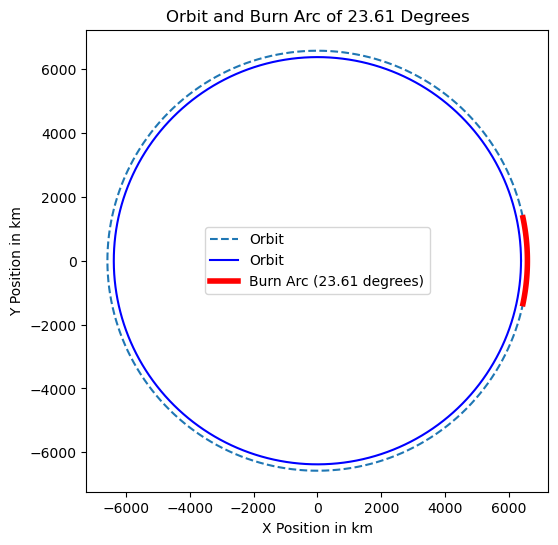

In [90]:
Pc0 = 7.5e5
expansion_ratio = 85
Nozzle_index = nozzle_expansion_ratio0.index(expansion_ratio)
result = rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=Pc0, dt=Rocket_Performance_Library[Pc0]['dt'][Nozzle_index], OF=5.2, Pa=0, g0=9.807, mass_dry=Rocket_Performance_Library[Pc0]['kickstage_dry_mass'][Nozzle_index]+100, nozzle_expansion_ratio=expansion_ratio, density_ox=1573.2, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=6.35e-05, n=0.5, iter_num=500, CEA_res = set_of_cea_results[Pc0][expansion_ratio], insul_percentage=1.0, casing_percentage=1.0, disp=True)

In [62]:
local_min_mass = []
local_min_index = []
local_min_dt = []
for i in Pressure_Keys:
    local_min_mass.append(min(Rocket_Performance_Library[i]['wet_mass']))
    local_min_index.append(Rocket_Performance_Library[i]['wet_mass'].index(min(Rocket_Performance_Library[i]['wet_mass'])))
    local_min_dt.append(Rocket_Performance_Library[i]['dt'][Rocket_Performance_Library[i]['wet_mass'].index(min(Rocket_Performance_Library[i]['wet_mass']))])
    
global_min_mass = min(local_min_mass)
global_min_index = local_min_mass.index(global_min_mass)

print(local_min_mass)
print(local_min_index)
print(global_min_mass)
print(global_min_index)
print(local_min_dt)
print(np.sqrt(np.array(local_min_dt)**2*np.array([75,70,70,70,70,70,70,70,70,70])))


[700.2820652109112, 686.8550096415523, 679.919795854355, 677.0472761976891, 675.3430004023793, 671.9779481140891, 670.366403094305, 669.3255248930958, 668.5561457033284, 667.9878516725515]
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7]
667.9878516725515
9
[0.14885267906689337, 0.09326020491771547, 0.0657154822388471, 0.05359038605644798, 0.046383302900842575, 0.032765810877386406, 0.026746079553181163, 0.023158759978785644, 0.02071096342947574, 0.01890742709868387]
[1.28910201 0.78027086 0.54981517 0.44836934 0.38807055 0.27413844
 0.22377376 0.19376009 0.17328035 0.15819088]


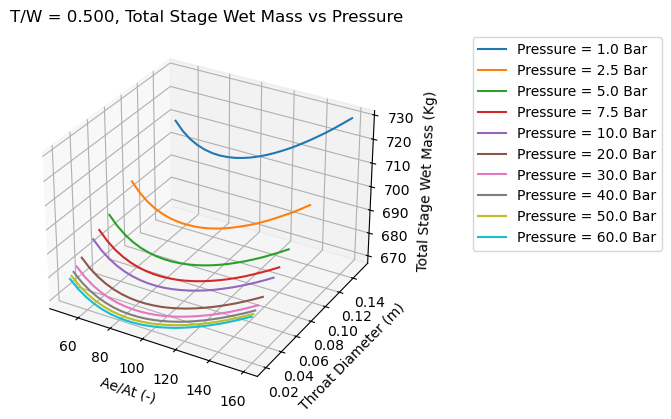

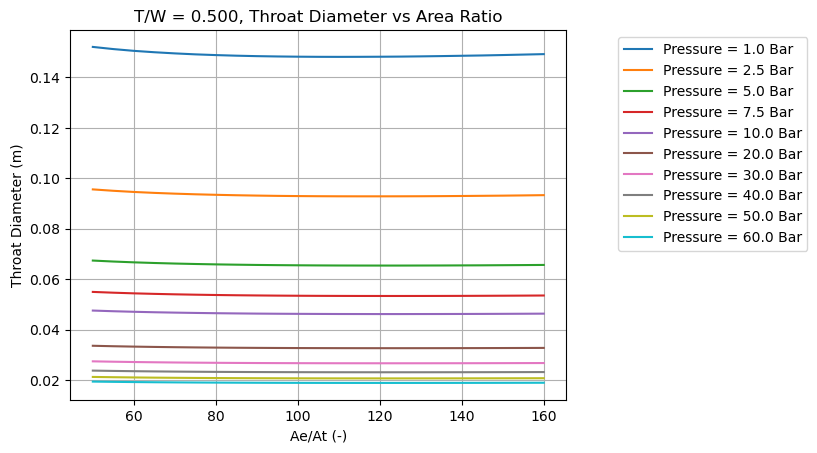

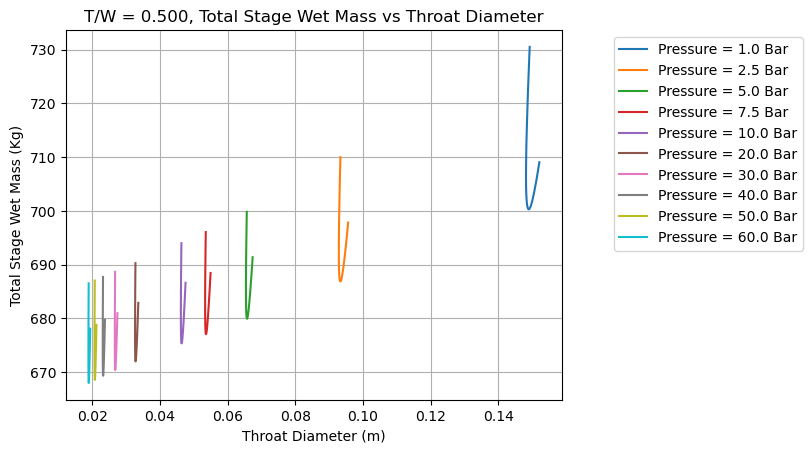

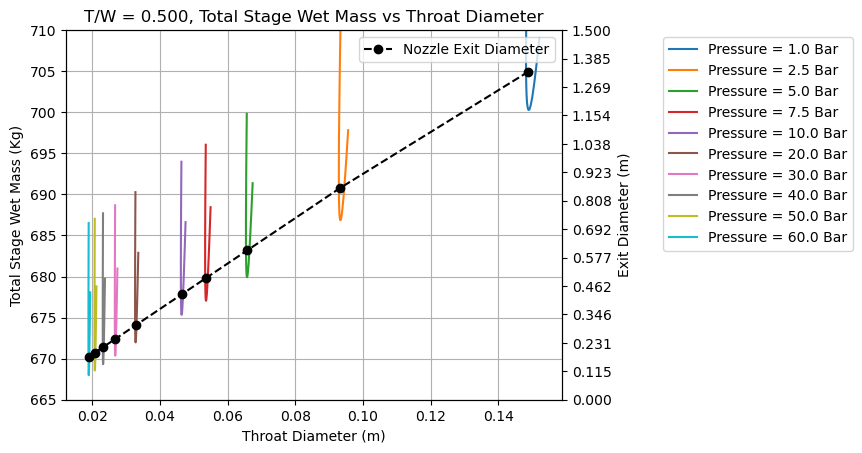

[700.2820652109112, 686.8550096415523, 679.919795854355, 677.0472761976891, 675.3430004023793, 671.9779481140891, 670.366403094305, 669.3255248930958, 668.5561457033284, 667.9878516725515]


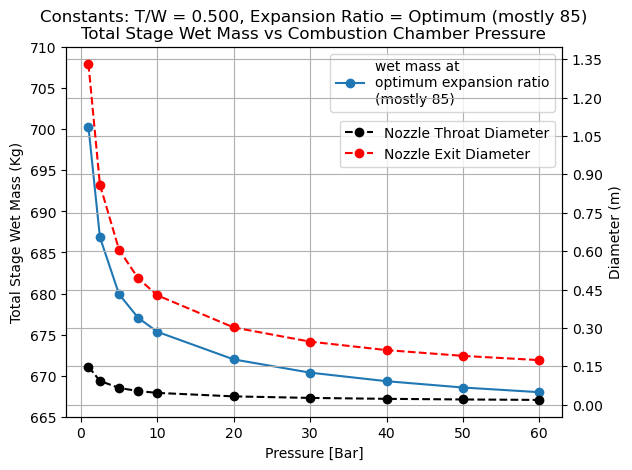

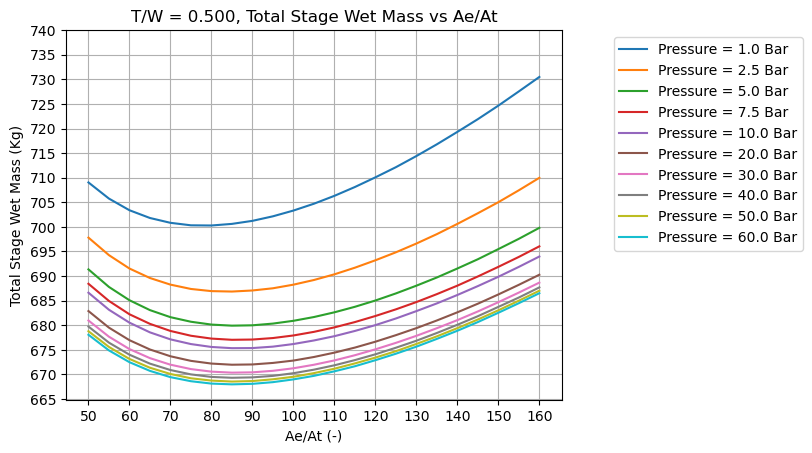

In [105]:

#print(Rocket_Performance_Library[10e5]['dt'])
#print(Rocket_Performance_Library[10e5]['wet_mass'])


#3D Chart
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in Pressure_Keys:
    
    # Make data.
    X = np.array(nozzle_expansion_ratio0)
    Y = np.array(Rocket_Performance_Library[i]['dt'])
    Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    ax.plot(X, Y, Z, label='Pressure = ' + str(i/1e5) + ' Bar' )
    
plt.legend(loc='upper right', bbox_to_anchor=(1.75,1))
plt.title('T/W = 0.500, Total Stage Wet Mass vs Pressure')
plt.xlabel('Ae/At (-)')
plt.ylabel('Throat Diameter (m)')
ax.set_zlabel('Total Stage Wet Mass (Kg)')
plt.show()

#Throat Diameter vs Area Ratio
fig = plt.figure()
ax = fig.add_subplot(111)

for i in Pressure_Keys:
    
    # Make data.
    X = np.array(nozzle_expansion_ratio0)
    Y = np.array(Rocket_Performance_Library[i]['dt'])
    Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    ax.plot(X, Y, '-', label='Pressure = ' + str(i/1e5) + ' Bar')
    
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.title('T/W = 0.500, Throat Diameter vs Area Ratio')
plt.xlabel('Ae/At (-)')
plt.ylabel('Throat Diameter (m)')
#plt.gca().set_aspect(5000)
plt.grid()
plt.show()


#Total Wet Mass vs Throat Diameter
fig = plt.figure()
ax = fig.add_subplot(111)

for i in Pressure_Keys:
    
    Y = np.array(Rocket_Performance_Library[i]['dt'])
    Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    ax.plot(Y, Z, '-', label='Pressure = ' + str(i/1e5) + ' Bar')
    
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.title('T/W = 0.500, Total Stage Wet Mass vs Throat Diameter')
plt.xlabel('Throat Diameter (m)')
plt.ylabel('Total Stage Wet Mass (Kg)')
plt.grid()
plt.show()

#Total Wet Mass vs Throat Diameter ZOOMED
fig = plt.figure()
ax = fig.add_subplot(111)

Dt = []
count = 0
for i in Pressure_Keys:
    Dt.append(Rocket_Performance_Library[i]['dt'][local_min_index[count]])
    count += 1
#Dt = [0.146666135002613, 0.09317758690360858, 0.06605601318585663, 0.05400992113743822, 0.046816168877520846, 0.03316796672401447, 0.027106376900970404, 0.023488241438720907, 0.021016293343071965, 0.01919078663249976]

De  = np.sqrt(np.array(Dt)**2*[nozzle_expansion_ratio0[i] for i in local_min_index])
#De = [1.27016599,0.77957962,0.55266426,0.45187942,0.39169217,0.27750312,0.22678822,0.19651673,0.17583493,0.16056164]

#min_mass = [695.2646877041357, 694.8725157368589, 695.1525683801979, 695.2996252200584, 695.3639827518718, 695.2611314095342, 695.0338218526499, 694.8419933135727, 694.6517157157984, 694.5153019334359]
#dt_list = []
#label_list = []
for i in Pressure_Keys:
    
    Y = np.array(Rocket_Performance_Library[i]['dt'])
    Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    ax.plot(Y, Z, '-', label='Pressure = ' + str(i/1e5) + ' Bar')
    #ax.plot(Dt[i],min_mass[i],'o', label='Pressure = ' + str(Pressure_Keys[i]/1e5) + ' Bar')
    #dt_list.append(Rocket_Performance_Library[Pressure_Keys[i]]['dt'])
    #label_list.append('Pressure = ' + str(i/1e5) + ' Bar')

#ax.plot(dt_list,min_mass,'ro-')
ax.set_xlabel('Throat Diameter (m)')
ax.set_ylabel('Total Stage Wet Mass (Kg)')




ax.set_ylim([665,710])

ax2 = ax.twinx()
ax2.plot(Dt, De, '--ok', label = 'Nozzle Exit Diameter')
ax2.set_ylabel('Exit Diameter (m)')
ax2.set_yticks(np.linspace(0,1.5,14))

ax.legend(loc='upper right', bbox_to_anchor=(1.6,1))
ax2.legend()
plt.title('T/W = 0.500, Total Stage Wet Mass vs Throat Diameter')

ax.grid()
plt.show()


#Total Wet Mass vs Throat Diameter ZOOMED (Lightest Only)
fig = plt.figure()
ax = fig.add_subplot(111)

#Dt = [0.146666135002613, 0.09317758690360858, 0.06605601318585663, 0.05400992113743822, 0.046816168877520846, 0.03316796672401447, 0.027106376900970404, 0.023488241438720907, 0.021016293343071965, 0.01919078663249976]
#De = [1.27016599,0.77957962,0.55266426,0.45187942,0.39169217,0.27750312,0.22678822,0.19651673,0.17583493,0.16056164]

min_mass = [Rocket_Performance_Library[Pressure_Keys[i]]['wet_mass'][local_min_index[i]] for i in range(len(Pressure_Keys))]
print(min_mass)
#min_mass = [695.2646877041357, 694.8725157368589, 695.1525683801979, 695.2996252200584, 695.3639827518718, 695.2611314095342, 695.0338218526499, 694.8419933135727, 694.6517157157984, 694.5153019334359]
dt_list = []
label_list = []
'''
for i in range(len(Pressure_Keys)):
    
    #Y = np.array(Rocket_Performance_Library[i]['dt'])
    #Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    #ax.plot(Y, Z, '-', label='Pressure = ' + str(i/1e5) + ' Bar')
    ax.plot(Dt[i],min_mass[i],'o', label='Pressure = ' + str(Pressure_Keys[i]/1e5) + ' Bar')
    #dt_list.append(Rocket_Performance_Library[Pressure_Keys[i]]['dt'])
    #label_list.append('Pressure = ' + str(i/1e5) + ' Bar')
    
#ax.plot(dt_list,min_mass,'ro-')
ax.set_xlabel('Throat Diameter (m)')
ax.set_ylabel('Total Stage Wet Mass (Kg)')
'''

ax.plot(np.array(Pressure_Keys)/1e5,min_mass,'-o', label='wet mass at \noptimum expansion ratio\n(mostly 85)')

#ax.plot(dt_list,min_mass,'ro-')
ax.set_xlabel('Pressure [Bar]')
ax.set_ylabel('Total Stage Wet Mass (Kg)')
ax.set_ylim([665,710])

ax2 = ax.twinx()
ax2.plot(np.array(Pressure_Keys)/1e5, Dt, '--ok', label='Nozzle Throat Diameter')
ax2.plot(np.array(Pressure_Keys)/1e5, De, '--or', label='Nozzle Exit Diameter')

ax2.set_ylabel('Diameter (m)')
ax2.set_yticks(np.linspace(0,1.35,10))

plt.title('Constants: T/W = 0.500, Expansion Ratio = Optimum (mostly 85)\nTotal Stage Wet Mass vs Combustion Chamber Pressure')

ax.grid(axis = 'x')
ax2.grid()
ax.legend()
ax2.legend(bbox_to_anchor=(1,0.82))
plt.show()


#Total Wet Mass vs Area Ratio
fig = plt.figure()
ax = fig.add_subplot(111)

for i in Pressure_Keys:
    
    # Make data.
    X = np.array(nozzle_expansion_ratio0)
    Z = np.array(Rocket_Performance_Library[i]['wet_mass'])
    ax.plot(X, Z, '-', label='Pressure = ' + str(i/1e5) + ' Bar')
    
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))
plt.title('T/W = 0.500, Total Stage Wet Mass vs Ae/At')
plt.xlabel('Ae/At (-)')
plt.ylabel('Total Stage Wet Mass (Kg)')
plt.grid()
plt.xticks(range(50,170,10))
plt.yticks(range(665,745,5))
plt.show()